In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#import seaborn as sns

%matplotlib inline
from keras.utils import np_utils

train_df = pd.read_csv('data/train.csv', sep=',', header=0)
test_df = pd.read_csv('data/test.csv', sep=',', header=0)

import nltk
nltk.download('stopwords')
from nltk import RegexpTokenizer
from nltk.corpus import stopwords

#removing seemingly useless stopwords decreases performance ~ 1%
def removePunktAndStopwords(phrases):
    toInclude = set(['above','below','between','but','couldn','didn','doesn','down',
                     'few','hadn','haven','isn','just','mightn','mustn','most','needn','nor',
                     'not','off','once','only','out','over','should','shouldn','some',
                     'very','wasn','weren','won','wouldn','again','against','all',
                     'any','aren','you','in','how','what','why','who','will','there'])
    stop_wordsLarge = set(stopwords.words('english'))
    stop_words = set([w for w in stop_wordsLarge if w not in toInclude])
    tokenizer = RegexpTokenizer('[a-z]\w+')
    docs_toke = [tokenizer.tokenize(doc.lower()) for doc in phrases]
    stopwordsremoved = [[t for t in temp if t not in stop_words] for temp in docs_toke]
    return np.asarray([" ".join(w) for w in stopwordsremoved])


train_df = train_df.fillna(" ")
#shuffle trainset
train_df = train_df.sample(frac=1)

test_df = test_df.fillna(" ")

print(train_df.shape)
train_df.head(2)

train_df['question2'] = removePunktAndStopwords(train_df['question2'])
train_df['question1'] = removePunktAndStopwords(train_df['question1'])

[nltk_data] Downloading package stopwords to /home/ubuntu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
(404290, 6)


In [ ]:
#rebalance training set
#incr. neg. cases by 287% => 
#select
pos_train = train_df[is_duplicate == 1]
neg_train = train_df[is_duplicate == 0]

# Now we oversample the negative class
# There is likely a much more elegant way to do this...
p = 0.165
scale = ((len(pos_train) / (len(pos_train) + len(neg_train))) / p) - 1


In [ ]:
while scale > 1:
    neg_train = pd.concat([neg_train, neg_train])
    scale -=1
neg_train = pd.concat([neg_train, neg_train[:int(scale * len(neg_train))]])
print(len(pos_train) / (len(pos_train) + len(neg_train)))
x_train = pd.concat([pos_train, neg_train])
y_train = (np.zeros(len(pos_train)) + 1).tolist() + np.zeros(len(neg_train)).tolist()
del pos_train, neg_train

In [ ]:
#add features
import difflib
def diff_ratios(st1, st2):
    seq = difflib.SequenceMatcher()
    seq.set_seqs(str(st1).lower(), str(st2).lower())
    return seq.ratio()
train_df['z_match_ratio'] = train_df.apply(lambda r: diff_ratios(r.question1, r.question2), axis=1)


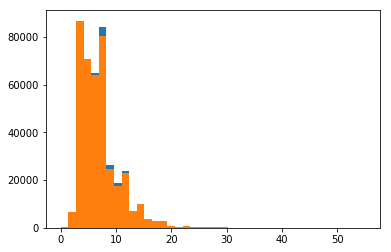

In [15]:
questions2 = train_df["question2"].values
length2 = np.array([len(x.split()) for x in questions2])
questions1 = train_df["question1"].values
length1 = np.array([len(x.split()) for x in questions1])
plt.figure()

#test
questions1 = train_df["question1"].values
length1 = np.array([len(x.split()) for x in questions1])
plt.figure()

plt.hist(length1,40,range=[0,55])
plt.hist(length2,40,range=[0,55])
plt.show()

In [16]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
MAX_SEQUENCE_LENGTH = 20
EMBEDDING_DIM = 300


toke = Tokenizer()
toke.fit_on_texts(np.concatenate([questions1,questions2],axis=0))

sequences1 = toke.texts_to_sequences(questions1)
sequencesReverse1 = [s[::-1] for s in sequences1]
sequences2 = toke.texts_to_sequences(questions2)
sequencesReverse2 = [s[::-1] for s in sequences2]


word_index = toke.word_index
X_train_forward1 = pad_sequences(sequences1, maxlen=MAX_SEQUENCE_LENGTH)
X_train_reverse1 = pad_sequences(sequencesReverse1, maxlen=MAX_SEQUENCE_LENGTH)
X_train_forward2 = pad_sequences(sequences2, maxlen=MAX_SEQUENCE_LENGTH)
X_train_reverse2 = pad_sequences(sequencesReverse2, maxlen=MAX_SEQUENCE_LENGTH)

y_train = train_df["is_duplicate"].values #np_utils.to_categorical()


#load glove vectors
#download them from http://nlp.stanford.edu/data/glove.6B.zip
embeddings_index = {}
GLOVE_DIR = '../data/'
import os
f = open(os.path.join(GLOVE_DIR, 'glove.6B.%id.txt' %EMBEDDING_DIM))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Found %s word vectors.' % len(embeddings_index))
#take only word vecs that are in training dictionary
#embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM)) # like that unable to learn unknown wordsembeddings 

embedding_matrix = np.random.uniform(-0.1,0.1,size=(len(word_index) + 1, EMBEDDING_DIM))
found = 0
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        found +=1
        embedding_matrix[i] = embedding_vector
        
print('Using %i word vectors of total vocabulary size: %i ' %(found,len(word_index)))

Found 400000 word vectors.
Using 59020 word vectors of total vocabulary size: 81601 


In [28]:
#LSTM with embedding trainable
from keras.models import Model
from keras.layers import Input
from keras.optimizers import Adam
from keras.layers import Dense, Dropout, Activation, Embedding, BatchNormalization, Convolution1D, GlobalMaxPooling1D
from keras.layers import LSTM
from keras.layers.merge import Concatenate
from keras.layers.advanced_activations import PReLU

opt = Adam(lr=0.001,beta_1=0.5)
inp_shape = X_train_forward1.shape[1:]
filter_length = 5
nb_filter = 64
pool_length = 4
#MODEL 1: bidirectional LSTM
#shared layers
shared_embedding = Embedding(len(word_index) + 1,
              EMBEDDING_DIM,
              weights=[embedding_matrix],
              input_length=MAX_SEQUENCE_LENGTH,
              trainable=False,
              input_shape=inp_shape)
shared_lstm_forward = LSTM(400, return_sequences=False, dropout=0.35, recurrent_dropout=0.35)
shared_lstm_backward = LSTM(400, return_sequences=False, dropout=0.35, recurrent_dropout=0.35)

#QUESTION1
inpONE_forward = Input(shape=inp_shape)
xf = shared_embedding(inpONE_forward)
xf = shared_lstm_forward(xf)

inpONE_reverse = Input(shape=inp_shape)
xr = shared_embedding(inpONE_reverse)
xr = shared_lstm_backward(xr)
x1 = Concatenate(axis=1)([xf,xr])


#QUESTION2
inpTWO_forward = Input(shape=inp_shape)
xf = shared_embedding(inpTWO_forward)
xf = shared_lstm_forward(xf)

inpTWO_reverse = Input(shape=inp_shape)
xr = shared_embedding(inpTWO_reverse)
xr = shared_lstm_backward(xr)
x2 = Concatenate(axis=1)([xf,xr])

#__________________________________
#MODEL 2: CNN
#shared: 
shared_conf1 = Convolution1D(nb_filter=nb_filter,
                         filter_length=filter_length,
                         border_mode='valid',
                         activation='relu',
                         subsample_length=1)
shared_conf2 = Convolution1D(nb_filter=nb_filter,
                         filter_length=filter_length,
                         border_mode='valid',
                         activation='relu',
                         subsample_length=1)
shared_pooling = GlobalMaxPooling1D()
#Q1
inp_cnn_1 = Input(shape=inp_shape)
cnn_1 = shared_embedding(inp_cnn_1)
cnn_1 = shared_conf1(cnn_1)
cnn_1 = Dropout(0.2)(cnn_1)

cnn_1 = shared_conf2(cnn_1)
cnn_1 = shared_pooling(cnn_1)
cnn_1 = Dropout(0.2)(cnn_1)

cnn_1 = Dense(300)(cnn_1)
cnn_1 = Dropout(0.2)(cnn_1)
cnn_1 = BatchNormalization()(cnn_1)
#Q2
inp_cnn_2 = Input(shape=inp_shape)
cnn_2 = shared_embedding(inp_cnn_2)
cnn_2 = shared_conf1(cnn_2)
cnn_2 = Dropout(0.2)(cnn_2)

cnn_2 = shared_conf2(cnn_2)
cnn_2 = shared_pooling(cnn_2)
cnn_2 = Dropout(0.2)(cnn_2)

cnn_2 = Dense(300)(cnn_2)
cnn_2 = Dropout(0.2)(cnn_2)
cnn_2 = BatchNormalization()(cnn_2)

#_________________________________
# COMBINE
x = Concatenate(axis=1)([x1,x2,cnn_1,cnn_2])
x = Dropout(0.35)(x)

x = BatchNormalization()(x)
x = Dense(500)(x)
x = PReLU()(x)
x = Dropout(0.35)(x)

x = BatchNormalization()(x)
x = Dense(500)(x)
x = PReLU()(x)
x = Dropout(0.35)(x)

x = BatchNormalization()(x)
x = Dense(300)(x)
x = PReLU()(x)
x = Dropout(0.35)(x)

x = BatchNormalization()(x)
pred = Dense(1,activation='sigmoid')(x)

model = Model([inpONE_forward,inpONE_reverse,inpTWO_forward,inpTWO_reverse,inp_cnn_1,inp_cnn_2],pred)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['binary_accuracy'])
model.summary()

/home/ubuntu/anaconda2/envs/py36/lib/python3.6/site-packages/keras/legacy/interfaces.py:86: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", filters=64, kernel_size=5, strides=1, padding="valid")`
  '` call to the Keras 2 API: ' + signature)


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_38 (InputLayer)            (None, 20)            0                                            
____________________________________________________________________________________________________
input_39 (InputLayer)            (None, 20)            0                                            
____________________________________________________________________________________________________
embedding_8 (Embedding)          (None, 20, 300)       24480600                                     
____________________________________________________________________________________________________
conv1d_9 (Conv1D)                (None, 16, 64)        96064                                        
___________________________________________________________________________________________

In [ ]:
from keras.utils import plot_model
plot_model(model, to_file='model.png')

In [31]:
from keras.callbacks import ModelCheckpoint
checkpointer = ModelCheckpoint(filepath="tmp/weights_6.hdf5", verbose=1, save_best_only=True)

losses = model.fit([X_train_forward1,X_train_reverse1,X_train_forward2,X_train_reverse2,X_train_forward1,X_train_forward2],
                  y_train,
                  epochs=5,
                  batch_size=512,
                  verbose=1,
                  validation_split=0.1,
                  callbacks=[checkpointer])




Train on 363861 samples, validate on 40429 samples
Epoch 1/5
363861/363861 [==============================] - 302s - loss: 0.3115 - binary_accuracy: 0.8596 - val_loss: 0.3782 - val_binary_accuracy: 0.8212
Epoch 2/5
363861/363861 [==============================] - 303s - loss: 0.3021 - binary_accuracy: 0.8647 - val_loss: 0.3758 - val_binary_accuracy: 0.8250
Epoch 3/5
363861/363861 [==============================] - 302s - loss: 0.2925 - binary_accuracy: 0.8697 - val_loss: 0.3825 - val_binary_accuracy: 0.8243
Epoch 4/5
363861/363861 [==============================] - 302s - loss: 0.2849 - binary_accuracy: 0.8730 - val_loss: 0.3858 - val_binary_accuracy: 0.8220
Epoch 5/5
363861/363861 [==============================] - 301s - loss: 0.2776 - binary_accuracy: 0.8768 - val_loss: 0.3773 - val_binary_accuracy: 0.8297


/home/ubuntu/anaconda2/envs/py36/lib/python3.6/site-packages/matplotlib/legend.py:326: UserWarning: Unrecognized location "lower_left". Falling back on "best"; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center

  six.iterkeys(self.codes))))


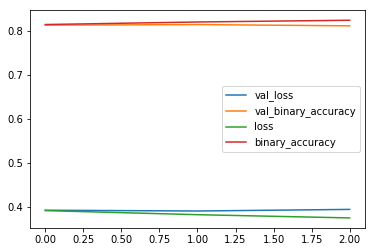

In [20]:
keys = list(losses.history.keys())
for key in keys:
    plt.plot(losses.history.get(key),label=key)
    
plt.legend(loc="lower_left")
plt.show()

In [ ]:
from keras.models import load_model
#load_model("tmp/weights_6.hdf5")
test_df = test_df.fillna(" ")
test_questions1 = test_df["question1"].values
test_questions2 = test_df["question2"].values

seqsTest1 = toke.texts_to_sequences(test_questions1)
seqsTestReverse1 = [s[::-1] for s in seqsTest1]
X_test_forward1 = pad_sequences(seqsTest1, maxlen=MAX_SEQUENCE_LENGTH)
X_test_reverse1 = pad_sequences(seqsTestReverse1, maxlen=MAX_SEQUENCE_LENGTH)
seqsTest2 = toke.texts_to_sequences(test_questions2)
seqsTestReverse2 = [s[::-1] for s in seqsTest2]
X_test_forward2 = pad_sequences(seqsTest2, maxlen=MAX_SEQUENCE_LENGTH)
X_test_reverse2 = pad_sequences(seqsTestReverse2, maxlen=MAX_SEQUENCE_LENGTH)

preds = model.predict([X_test_forward1,X_test_reverse1,X_test_forward2,X_test_reverse2,X_test_forward1,X_test_forward2],batch_size=512,verbose=1)



test_df["is_duplicate"] = pd.Series(preds[:,0],index=test_df.index)
header = ["test_id", "is_duplicate"]
test_df.to_csv('submissions/predictions_6.csv', columns = header,index=False)

1615872/2345796 [===================>..........] - ETA: 214s

In [ ]:
plt.hist(preds,50)

In [ ]:
print(np.sum(preds<0.5)/preds.shape[0])
print(np.sum(y_train == 0)/y_train.shape[0])
idx = np.nonzero(preds>0.999)[0]
test_df.iloc[idx[:5],1:3].values